In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Run this to attack a trained model via TrainModel. 
Use the "loadFullModel" submethod to load in an already trained model (trained via TrainModel)
The main attack function is "runAttacks" which runs attacks on trained models
"""
import warnings
warnings.filterwarnings("ignore")

import os
import tensorflow as tf
#tf.compat.v1.enable_eager_execution
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from cleverhans.attacks import Noise, CarliniWagnerL2, MaxConfidence, FastGradientMethod, BasicIterativeMethod, DeepFool, MomentumIterativeMethod, ProjectedGradientDescent
from Model_Implementations import Model_Softmax_Baseline, Model_Logistic_Baseline, Model_Logistic_Ensemble, Model_Tanh_Ensemble, Model_Tanh_Baseline
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras import backend
import numpy as np
import scipy.linalg
from scipy import stats
import matplotlib.pyplot as plt

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 32, 32, 3)         0         
_________________________________________________________________
lambda (Lambda)              (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
lwta__conv2d__activation (LW (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
______________________________________________

Adv accuracy for model softmax_baseline_CIFAR10 :  0.85

Running Blind Spot attack, alpha=0.8:
Adv accuracy for model softmax_baseline_CIFAR10 :  0.81

Running random attack:
Prob. that  softmax_baseline_CIFAR10  < 0.9 on random data:  0.252
Running Noise attack:
Adv accuracy for model softmax_baseline_CIFAR10 :  0.819



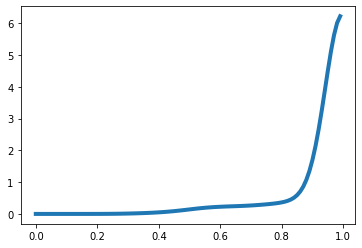

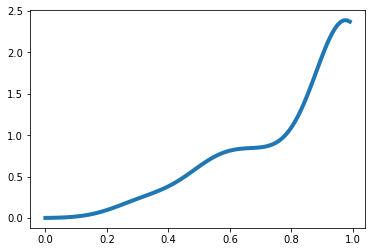

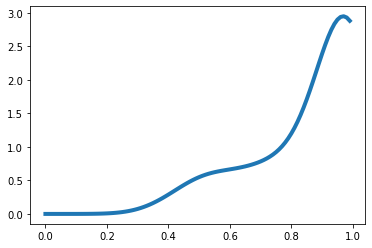

In [2]:
model_path = 'models/'  #path with saved model parameters 
sess =  backend.get_session()
backend.set_learning_phase(0) #need to do this to get CleverHans to work with batchnorm


#Dataset-specific parameters - should be same as those used in TrainModel
DATA_DESC = 'CIFAR10'; (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
epochs=None; weight_save_freq=None
num_classes=10  #how many classes (categories) are in this dataset?
Y_train = np.squeeze(Y_train); Y_test = np.squeeze(Y_test)
num_filters_std = [32, 64, 128]; num_filters_ens=[32, 64, 128]; num_filters_ens_2=16; dropout_rate_std=0.0; dropout_rate_ens=0.0; weight_decay = 0 
model_rep_baseline=2; model_rep_ens=2; DATA_AUGMENTATION_FLAG=1; BATCH_NORMALIZATION_FLAG=1
num_channels = 3; inp_shape = (32,32,3); lr=1e-4; batch_size=80;
noise_stddev = 0.032; blend_factor = .032

#Attack parameters
eps_val = 8/255.0; PGD_iters = 200; eps_iter=(2/3)*eps_val; 
eps_range = np.linspace(0, 0.33, 10)
noise_eps=0.1


# DATA PRE-PROCESSING
X_train = (X_train/255).astype(np.float32);  X_test = (X_test/255).astype(np.float32)
#reshape (add third (image) channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],num_channels); X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],num_channels)
X_valid = X_test[1000:2000]; Y_valid = Y_test[1000:2000]; #validation data, used to attack model
X_train = X_train-0.5; X_test = X_test-0.5; X_valid = X_valid-0.5; #map to range (-0.5,0.5)
data_dict = {'X_train':X_train, 'Y_train_cat':Y_train, 'X_test':X_test, 'Y_test_cat':Y_test}
X_random = np.random.rand(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],X_valid.shape[3])-0.5; X_random = X_random.astype(np.float32)




#Model definition of the model we want to attack; should be same as the definition used in TrainModel
name = 'softmax_baseline'+'_'+DATA_DESC; num_chunks=1
M = np.eye(num_classes).astype(np.float32)
#output_activation = 'sigmoid';
def output_activation(x):
    return tf.nn.softmax(x)
base_model=None
params_dict = {'weight_decay':weight_decay, 'num_filters_std':num_filters_std, 'BATCH_NORMALIZATION_FLAG':BATCH_NORMALIZATION_FLAG, 'DATA_AUGMENTATION_FLAG':DATA_AUGMENTATION_FLAG, 'M':M, 'model_rep':model_rep_baseline, 'base_model':base_model, 'num_chunks':num_chunks, 'output_activation':output_activation,  'batch_size':batch_size, 'epochs':epochs, 'lr':lr, 'dropout_rate':dropout_rate_std,  'blend_factor':blend_factor, 'inp_shape':inp_shape, 'noise_stddev':noise_stddev, 'weight_save_freq':weight_save_freq, 'name':name, 'model_path':model_path}
m4 = Model_Logistic_Baseline(data_dict, params_dict)
m4.loadFullModel() #load in the saved model, which should have already been trained first via TrainModel

m4.legend = 'TEns16'; 
m4.X_valid = X_valid; m4.Y_valid = Y_valid; 
m4.X_test = X_test; m4.Y_test = Y_test; 
m4.X_random = X_random; 
m4.minval = -0.5; m4.maxval = 0.5




def benignAccuracy(model, X, Y):
    
    acc_vec=[]; probs_benign_list=[]
    for rep in np.arange(0, X.shape[0], 1000):
        x = X[rep:rep+1000]
        probs_benign = sess.run(model.predict(tf.convert_to_tensor(x)))        
        acc= np.mean(np.argmax(probs_benign, 1)==Y[rep:rep+1000])
        acc_vec += [acc]
        probs_benign_list += list(np.max(probs_benign, 1))

        
    acc = np.mean(acc_vec)        
    print("Accuracy for model " + model.params_dict['name'] + " : ", acc)    
    return probs_benign_list


def wbAttack(model, attack, att_params, X, Y):
    sess =  backend.get_session()
    modelCH = model.modelCH()
    adv_model = attack(modelCH, sess=sess) 
    
    acc_vec=[]; probs_adv_list=[]
    inc=500
    for rep in np.arange(0, X.shape[0], inc):
        x = X[rep:rep+inc]
        y = Y[rep:rep+inc]
        X_adv = adv_model.generate(tf.convert_to_tensor(x), **att_params).eval(session=sess)   
        preds = np.argmax(sess.run(model.predict(tf.convert_to_tensor(X_adv))), 1)
        acc =  np.mean(np.equal(preds, y))
        probs_adv = np.max(sess.run(model.predict(tf.convert_to_tensor(X_adv))), 1)
        probs_adv = probs_adv[preds != y]
        acc= np.mean(np.equal(preds, y))
        acc_vec += [acc]
        probs_adv_list += list(probs_adv)

        
    acc = np.mean(acc_vec)        
    print("Adv accuracy for model " + model.params_dict['name'] + " : ", acc)    
    return probs_adv_list, acc, X_adv





def runAttacks(models_list):
    #CW attack
    for model in models_list:
        
        print(""); print(""); print("");
        print("Running tests on model: ", model.params_dict['name'])
        
        print("Clean accuracy of model:")
        probs_benign = benignAccuracy(model, model.X_test, model.Y_test)
        print("")
        
        print("Running PGD attack:")
        att_params = {'clip_min': model.minval, 'clip_max':model.maxval, 'eps':eps_val, 'eps_iter':eps_iter, 'nb_iter':PGD_iters,'ord':np.inf}
        probs_adv, junk, X_adv = wbAttack(model, ProjectedGradientDescent, att_params, model.X_valid, model.Y_valid)
        print("")
        
        print("Running CW attack:")
        att_params = {'clip_min': model.minval, 'clip_max':model.maxval,  'binary_search_steps':10, 'learning_rate':1e-3}
        probs_adv, junk, X_adv = wbAttack(model, CarliniWagnerL2, att_params, model.X_valid[0:100], model.Y_valid[0:100])
        print("")
        
        print("Running Blind Spot attack, alpha=0.8:")
        att_params = {'clip_min': model.minval, 'clip_max':model.maxval,  'binary_search_steps':10, 'learning_rate':1e-3}
        probs_adv, junk, X_adv = wbAttack(model, CarliniWagnerL2, att_params, 0.8*model.X_valid[0:100], model.Y_valid[0:100])
        print("")
        
                
        #Random ATTACK (0 SNR inputs)
        print("Running random attack:")
        probs_random = np.max(sess.run(model.predict(tf.convert_to_tensor(model.X_random))), 1)
        print('Prob. that ', model.params_dict['name'], ' < 0.9 on random data: ', np.mean(probs_random<0.9))
        
        #Noise ATTACK (low SNR inputs)
        print("Running Noise attack:")
        att_params = {'clip_min': model.minval, 'clip_max':model.maxval, 'eps':noise_eps}
        probs_noise, junk, X_adv = wbAttack(model, Noise, att_params, model.X_valid, model.Y_valid)
        print("")
        
    return probs_benign, probs_adv, probs_noise
        



models_list = [m4]
probs_benign, probs_adv, probs_noise = runAttacks(models_list)

plt.figure(1)
kernel = stats.gaussian_kde(probs_benign, bw_method=0.5)
plt.plot(np.arange(0, 1, .01), kernel.pdf(np.arange(0, 1, .01)), linewidth=4)   

plt.figure(2)
kernel = stats.gaussian_kde(probs_adv, bw_method=0.5)
plt.plot(np.arange(0, 1, .01), kernel.pdf(np.arange(0, 1, .01)), linewidth=4)   

plt.figure(3)
kernel = stats.gaussian_kde(probs_noise, bw_method=0.5)
plt.plot(np.arange(0, 1, .01), kernel.pdf(np.arange(0, 1, .01)), linewidth=4)   